In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats
from analysis import *

# Load and prepare data

In [2]:
# Load data
X_es = []
spikes = []
weights = []
for i in range(170, 170 + seeds_num_1):
    data = load_data("./data/seqlearn_cues_per_seed{}.pickle".format(i))
    X_es.append(data["X_e"])
    spikes.append(data["spikes"])
    weights.append(data["weights"])

In [3]:
# Helper function to get matches
def matches_frac(X_es, spikes, start_time):
    matches = []
    for i in tqdm(range(len(X_es))):
        clu_neurs = get_cluster_neurons(X_es[i])
        spikes_dic = spikes[i]
        firing_times = []
        for clu in range(clu_num):
            spikes_clu = get_spikes(clu_neurs[clu], spikes_dic, start_time)
            firing_times.append(rates_ftimes(spikes_clu, start_time, len(clu_neurs[clu]))[1])
        firing_times = np.array(firing_times).T
        spCCs = np.array(sp_corr(firing_times))
        matches.append(len(spCCs[spCCs>0.6])/len(spCCs))
    return np.array(matches)

In [4]:
# Get matches
af_time = growth_time + test_time + 2*relax_time + learn_time
matches_frac_bf = matches_frac(X_es, spikes, growth_time)
matches_frac_af1 = matches_frac(X_es, spikes, af_time)
matches_frac_af2 = matches_frac(X_es, spikes, af_time + test_time)
matches_frac_af3 = matches_frac(X_es, spikes, af_time + 2*test_time)

In [5]:
# Get difference in matches
matches_diff = np.zeros((3, 2))
matches_diff[0] = [np.mean(matches_frac_af1 - matches_frac_bf), stats.sem(matches_frac_af1 - matches_frac_bf)]
matches_diff[1] = np.mean(matches_frac_af2 - matches_frac_bf), stats.sem(matches_frac_af2 - matches_frac_bf)
matches_diff[2] = np.mean(matches_frac_af3 - matches_frac_bf), stats.sem(matches_frac_af3 - matches_frac_bf)

In [6]:
# Helper function to transform stored weights into weight matrices
def weights_to_matrix(weights, clu_neurs):
    clu_neurs = np.concatenate(clu_neurs)
    W = np.zeros((N_e, N_e))
    W[~np.eye(N_e, dtype=bool)] = weights
    W = W[clu_neurs, :]
    W = W[:, clu_neurs]
    return W

# Helper function to get forward and backward weights
def get_Ws(X_es, weights):
    W_fw = []
    W_bw = []
    for i in tqdm(range(len(X_es))):
        clu_neurs = get_cluster_neurons(X_es[i])
        weights_i = weights[i].T
        W_fw_i = []
        W_bw_i = []
        for weights_it in weights_i:
            W_it = weights_to_matrix(weights_it, [np.arange(N_e)])
            W_fw_it = 0
            W_bw_it = 0
            neur_num = 0
            for clu_a in range(clu_num-1):
                W_fw_it += np.sum(W_it[np.ix_(clu_neurs[clu_a], clu_neurs[clu_a+1])])
                W_bw_it += np.sum(W_it[np.ix_(clu_neurs[clu_a+1], clu_neurs[clu_a])])
                neur_num += len(clu_neurs[clu_a])*len(clu_neurs[clu_a+1])
            W_fw_i.append(W_fw_it / neur_num)
            W_bw_i.append(W_bw_it / neur_num)
        W_fw.append(W_fw_i)
        W_bw.append(W_bw_i)
    return np.array(W_fw), np.array(W_bw)

In [7]:
# Get forward and backward weights
af_time = 2*relax_time + learn_time + test_time + test_time_afper - 10*second
times_W = np.linspace(growth_time, growth_time + af_time, int(af_time/10*second)+1)
W_fw, W_bw = get_Ws(X_es, weights)

# Figure

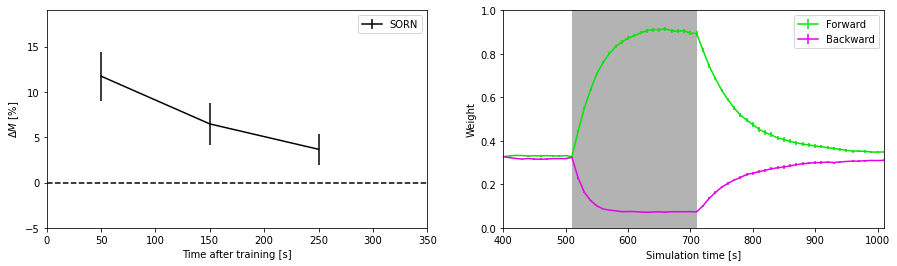

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Panel A
ax = axs[0]
ax.errorbar([50, 150, 250], 100*matches_diff[:, 0], yerr=100*matches_diff[:, 1], color="k", label="SORN")
ax.axhline(0, color="k", ls="--")
ax.legend()
ax.set_ylim(-5, 19)
ax.set_xlim(0, 350)
ax.set_xlabel("Time after training [s]")
ax.set_ylabel("$\Delta M$ [%]")

# Panel B
ax = axs[1]
ax.errorbar(times_W, np.mean(W_fw, 0), yerr=stats.sem(W_fw, 0), color=(0, 0.9, 0), label="Forward")
ax.errorbar(times_W, np.mean(W_bw, 0), yerr=stats.sem(W_bw, 0), color=(0.9, 0.0, 0.9), label="Backward")
ax.axvspan(growth_time + test_time+ relax_time, 
           growth_time + test_time + relax_time + learn_time, facecolor="0.7")
ax.legend()
ax.set_xlim(times_W[0], times_W[-1])
ax.set_ylim(0, 1)
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Weight")

plt.show()